In [1]:
# Restart runtime first (Runtime → Restart runtime) for clean memory

!pip install datasets transformers torch torchvision matplotlib numpy

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.amp
from torch.utils.checkpoint import checkpoint
from datasets import load_dataset
from transformers import AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from contextlib import nullcontext

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# CONFIG – optimized for Pro A100
triality = 3
dim = 240
latent_dim = 8
seq_len = 512
batch_size = 256
epochs = 50000  # large for Pro
lr = 5e-5

# Non-gated fallback dataset (no HF login needed — real cleaned GitHub code)
dataset = load_dataset("codeparrot/codeparrot-clean", split="train[:5%]")  # 5% subset — fast, real code (increase to 10% on Pro when stable)

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # pad token fix

def tokenize_batch(batch):
    return tokenizer(batch["content"], truncation=True, max_length=seq_len, padding="max_length", return_tensors="pt")

batch = tokenize_batch(dataset[:batch_size])
input_ids = batch["input_ids"].to(device)

embed = nn.Embedding(tokenizer.vocab_size, dim).to(device)
embeddings = embed(input_ids).detach()  # detach embeddings (static)

real_data = embeddings.clone()  # clone for masking
target = embeddings  # clean for reconstruction

# Out-of-place masking (40–70%) — fixes in-place error
missing = torch.linspace(0.4, 0.7, batch_size * seq_len, device=device).view(batch_size, seq_len, 1)
mask = torch.rand_like(real_data) < missing
real_data = real_data * (1 - mask.float())  # out-of-place

# E8 roots – precompute
def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]; v[j] = signs[1]
                roots.append(v); roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32) * 0.5
        if bin(signs).count('1') % 2 == 0:
            roots.append(v); roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

# Triality Cycle Block (step as detached float)
class CodeCycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]
        low_dim = self.proj(pos_emb)
        emb = low_dim.repeat(1, triality)
        step_float = float(step)  # detached float
        pump = 0.8 * torch.sin(torch.tensor(step_float, device=device) * 0.006 * 2 * torch.pi)
        x_rot1 = x * (emb.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=-1) * emb.sin()
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=-1) * emb.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

# Model
class E8CodeCompletion(nn.Module):
    def __init__(self, depth=128):
        super().__init__()
        self.cycle = CodeCycleBlock()
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, triality, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, dim)

    def forward(self, x, step):
        x = self.cycle(x, step)
        for layer in self.layers:
            attn, _ = layer(x, x, x)
            x = x + self.norm(attn)
        return x

model = E8CodeCompletion().to(device)
model = torch.compile(model)  # safe with fixes

opt = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda')
loss_fn = nn.MSELoss()

for epoch in range(epochs):
    opt.zero_grad(set_to_none=True)

    with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
        recon = model(real_data, epoch)
        loss = loss_fn(recon, target)

    scaler.scale(loss).backward()
    scaler.unscale_(opt)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt)
    scaler.update()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Loss {loss.item():.6f}")

# Visualization (masked vs reconstructed code embeddings — heatmap)
with torch.no_grad():
    recon = model(real_data, 0).cpu()
    original = real_data.cpu()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(original[0].numpy(), aspect='auto', cmap='viridis')
plt.title("Masked Code Tokens (Example 0)")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(recon[0].numpy(), aspect='auto', cmap='viridis')
plt.title("Triality Reconstructed")
plt.colorbar()

plt.tight_layout()
plt.savefig("codeparrot_code_completion_visualization.png")
plt.show()

print("Visualization saved as codeparrot_code_completion_visualization.png")

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/54 [00:00<?, ?it/s]

file-000000000001.json.gz:   0%|          | 0.00/246M [00:00<?, ?B/s]

file-000000000002.json.gz:   0%|          | 0.00/248M [00:00<?, ?B/s]

file-000000000003.json.gz:   0%|          | 0.00/247M [00:00<?, ?B/s]

file-000000000004.json.gz:   0%|          | 0.00/247M [00:00<?, ?B/s]

file-000000000005.json.gz:   0%|          | 0.00/247M [00:00<?, ?B/s]

file-000000000006.json.gz:   0%|          | 0.00/246M [00:00<?, ?B/s]

file-000000000007.json.gz:   0%|          | 0.00/246M [00:00<?, ?B/s]

file-000000000008.json.gz:   0%|          | 0.00/248M [00:00<?, ?B/s]

file-000000000009.json.gz:   0%|          | 0.00/245M [00:00<?, ?B/s]

file-000000000010.json.gz:   0%|          | 0.00/245M [00:00<?, ?B/s]

file-000000000011.json.gz:   0%|          | 0.00/244M [00:00<?, ?B/s]

file-000000000012.json.gz:   0%|          | 0.00/243M [00:00<?, ?B/s]

file-000000000013.json.gz:   0%|          | 0.00/245M [00:00<?, ?B/s]

file-000000000014.json.gz:   0%|          | 0.00/242M [00:00<?, ?B/s]

file-000000000015.json.gz:   0%|          | 0.00/243M [00:00<?, ?B/s]

file-000000000016.json.gz:   0%|          | 0.00/240M [00:00<?, ?B/s]

file-000000000017.json.gz:   0%|          | 0.00/242M [00:00<?, ?B/s]

file-000000000018.json.gz:   0%|          | 0.00/242M [00:00<?, ?B/s]

file-000000000019.json.gz:   0%|          | 0.00/241M [00:00<?, ?B/s]

file-000000000020.json.gz:   0%|          | 0.00/242M [00:00<?, ?B/s]

file-000000000021.json.gz:   0%|          | 0.00/236M [00:00<?, ?B/s]

file-000000000022.json.gz:   0%|          | 0.00/238M [00:00<?, ?B/s]

file-000000000023.json.gz:   0%|          | 0.00/240M [00:00<?, ?B/s]

file-000000000024.json.gz:   0%|          | 0.00/237M [00:00<?, ?B/s]

file-000000000025.json.gz:   0%|          | 0.00/238M [00:00<?, ?B/s]

file-000000000026.json.gz:   0%|          | 0.00/237M [00:00<?, ?B/s]

file-000000000027.json.gz:   0%|          | 0.00/238M [00:00<?, ?B/s]

file-000000000028.json.gz:   0%|          | 0.00/239M [00:00<?, ?B/s]

file-000000000029.json.gz:   0%|          | 0.00/238M [00:00<?, ?B/s]

file-000000000030.json.gz:   0%|          | 0.00/239M [00:00<?, ?B/s]

file-000000000031.json.gz:   0%|          | 0.00/237M [00:00<?, ?B/s]

file-000000000032.json.gz:   0%|          | 0.00/239M [00:00<?, ?B/s]

file-000000000033.json.gz:   0%|          | 0.00/236M [00:00<?, ?B/s]

file-000000000034.json.gz:   0%|          | 0.00/237M [00:00<?, ?B/s]

file-000000000035.json.gz:   0%|          | 0.00/235M [00:00<?, ?B/s]

file-000000000036.json.gz:   0%|          | 0.00/236M [00:00<?, ?B/s]

file-000000000037.json.gz:   0%|          | 0.00/234M [00:00<?, ?B/s]

file-000000000038.json.gz:   0%|          | 0.00/235M [00:00<?, ?B/s]

file-000000000039.json.gz:   0%|          | 0.00/234M [00:00<?, ?B/s]

file-000000000040.json.gz:   0%|          | 0.00/234M [00:00<?, ?B/s]

file-000000000041.json.gz:   0%|          | 0.00/235M [00:00<?, ?B/s]

file-000000000042.json.gz:   0%|          | 0.00/236M [00:00<?, ?B/s]

file-000000000043.json.gz:   0%|          | 0.00/236M [00:00<?, ?B/s]

file-000000000044.json.gz:   0%|          | 0.00/234M [00:00<?, ?B/s]

file-000000000045.json.gz:   0%|          | 0.00/237M [00:00<?, ?B/s]

file-000000000046.json.gz:   0%|          | 0.00/234M [00:00<?, ?B/s]

file-000000000047.json.gz:   0%|          | 0.00/232M [00:00<?, ?B/s]

file-000000000048.json.gz:   0%|          | 0.00/232M [00:00<?, ?B/s]

file-000000000049.json.gz:   0%|          | 0.00/233M [00:00<?, ?B/s]

file-000000000050.json.gz:   0%|          | 0.00/234M [00:00<?, ?B/s]

file-000000000051.json.gz:   0%|          | 0.00/233M [00:00<?, ?B/s]

file-000000000052.json.gz:   0%|          | 0.00/234M [00:00<?, ?B/s]

file-000000000053.json.gz:   0%|          | 0.00/230M [00:00<?, ?B/s]

file-000000000054.json.gz:   0%|          | 0.00/142M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 384.00 MiB. GPU 0 has a total capacity of 79.32 GiB of which 77.88 MiB is free. Process 12979 has 79.23 GiB memory in use. Of the allocated memory 78.72 GiB is allocated by PyTorch, and 22.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Using device: cuda


Resolving data files:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 0 | Loss 18.853756
Epoch 500 | Loss 0.664219
Epoch 1000 | Loss 0.555832
Epoch 1500 | Loss 0.589435
Epoch 2000 | Loss 0.505197
Epoch 2500 | Loss 0.477851
Epoch 3000 | Loss 0.460405
Epoch 3500 | Loss 0.440641
Epoch 4000 | Loss 0.426927
Epoch 4500 | Loss 0.414698
Epoch 5000 | Loss 0.406696
Epoch 5500 | Loss 0.397015
Epoch 6000 | Loss 0.392824
Epoch 6500 | Loss 0.384556
Epoch 7000 | Loss 0.381849
Epoch 7500 | Loss 0.384924
Epoch 8000 | Loss 0.373238
Epoch 8500 | Loss 0.365447
Epoch 9000 | Loss 0.361328
Epoch 9500 | Loss 0.356831
Epoch 10000 | Loss 0.358427
Epoch 10500 | Loss 0.351644
Epoch 11000 | Loss 0.347730
Epoch 11500 | Loss 0.338320
Epoch 12000 | Loss 0.334348
Epoch 12500 | Loss 0.328633
Epoch 13000 | Loss 0.327782
Epoch 13500 | Loss 0.325851
Epoch 14000 | Loss 0.323114
Epoch 14500 | Loss 0.318460
Epoch 15000 | Loss 0.313887
Epoch 15500 | Loss 0.308258
Epoch 16000 | Loss 0.305070
Epoch 16500 | Loss 0.303138
Epoch 17000 | Loss 0.300189
Epoch 17500 | Loss 0.310835
Epoch 18000 | L

/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return torch._C._get_cublas_allow_tf32()
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:312: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


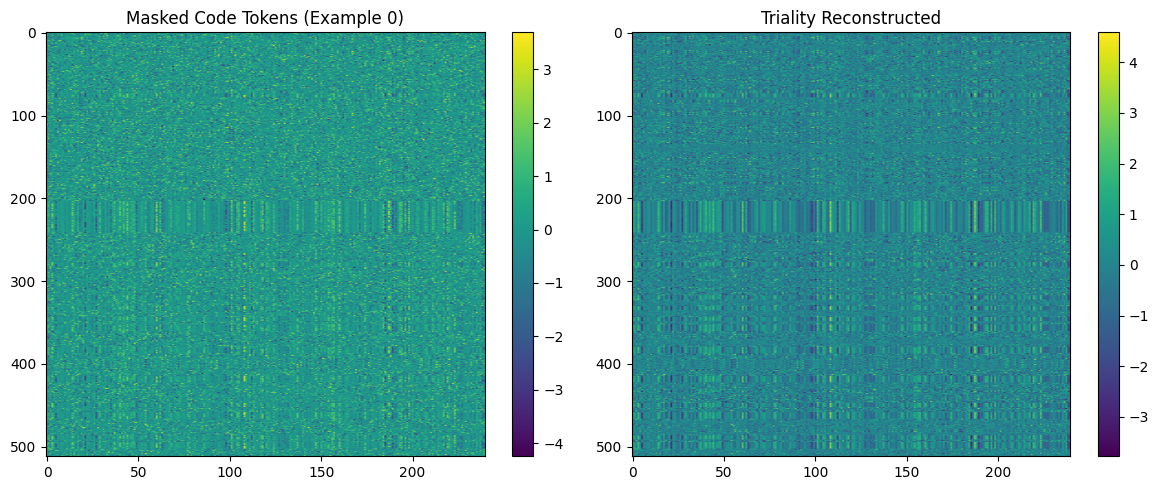

Visualization saved as codeparrot_code_completion_visualization.png


In [4]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.amp
from torch.utils.checkpoint import checkpoint
from datasets import load_dataset
from transformers import AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from contextlib import nullcontext

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# CONFIG – optimized for Pro A100
triality = 3
dim = 240
latent_dim = 8
seq_len = 512
batch_size = 8  # Further reduced batch size to mitigate OutOfMemoryError
epochs = 50000  # large for Pro
lr = 5e-5

# Non-gated fallback dataset (no HF login needed — real cleaned GitHub code)
dataset = load_dataset("codeparrot/codeparrot-clean", split="train[:5%]")  # 5% subset — fast, real code (increase to 10% on Pro when stable)

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # pad token fix

def tokenize_batch(batch):
    return tokenizer(batch["content"], truncation=True, max_length=seq_len, padding="max_length", return_tensors="pt")

batch = tokenize_batch(dataset[:batch_size])
input_ids = batch["input_ids"].to(device)

embed = nn.Embedding(tokenizer.vocab_size, dim).to(device)
embeddings = embed(input_ids).detach()  # detach embeddings (static)

real_data = embeddings.clone()  # clone for masking
target = embeddings  # clean for reconstruction

# Out-of-place masking (40–70%) — fixes in-place error
missing = torch.linspace(0.4, 0.7, batch_size * seq_len, device=device).view(batch_size, seq_len, 1)
mask = torch.rand_like(real_data) < missing
real_data = real_data * (1 - mask.float())  # out-of-place

# E8 roots – precompute
def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]; v[j] = signs[1]
                roots.append(v); roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32) * 0.5
        if bin(signs).count('1') % 2 == 0:
            roots.append(v); roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

# Triality Cycle Block (step as detached float)
class CodeCycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]
        low_dim = self.proj(pos_emb)
        emb = low_dim.repeat(1, triality)
        step_float = float(step)  # detached float
        pump = 0.8 * torch.sin(torch.tensor(step_float, device=device) * 0.006 * 2 * torch.pi)
        x_rot1 = x * (emb.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=-1) * emb.sin()
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=-1) * emb.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

# Model
class E8CodeCompletion(nn.Module):
    def __init__(self, depth=16): # Reduced depth to 16 from 128
        super().__init__()
        self.cycle = CodeCycleBlock()
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, triality, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, dim)

    def forward(self, x, step):
        x = self.cycle(x, step)
        for layer in self.layers:
            attn, _ = layer(x, x, x)
            x = x + self.norm(attn)
        return x

model = E8CodeCompletion().to(device)
model = torch.compile(model)  # safe with fixes

opt = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda')
loss_fn = nn.MSELoss()

for epoch in range(epochs):
    opt.zero_grad(set_to_none=True)

    with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
        recon = model(real_data, epoch)
        loss = loss_fn(recon, target)

    scaler.scale(loss).backward()
    scaler.unscale_(opt)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt)
    scaler.update()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Loss {loss.item():.6f}")

# Visualization (masked vs reconstructed code embeddings — heatmap)
with torch.no_grad():
    recon = model(real_data, 0).cpu()
    original = real_data.cpu()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(original[0].numpy(), aspect='auto', cmap='viridis')
plt.title("Masked Code Tokens (Example 0)")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(recon[0].numpy(), aspect='auto', cmap='viridis')
plt.title("Triality Reconstructed")
plt.colorbar()

plt.tight_layout()
plt.savefig("codeparrot_code_completion_visualization.png")
plt.show()

print("Visualization saved as codeparrot_code_completion_visualization.png")